In [27]:
import numpy as np
from scipy.stats import binom
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [56]:
def prior(p):
    if 0 <= p <= 1:
        return 1
    else:
        return 0
def posterior(p,k=6,n=9):
    return prior(p)*binom.pmf(k,n,p)

In [79]:
pgrid=np.linspace(0,1,1000)

In [80]:
post_grid=np.array([posterior(i) for i in pgrid])
post_grid=post_grid/post_grid.sum()

In [81]:
nsamp=10000
samples=np.random.choice(pgrid, nsamp, p=post_grid)

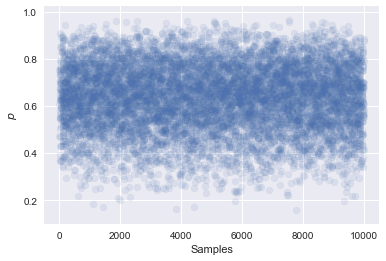

In [82]:
plt.scatter(range(nsamp),samples, alpha=0.1)
plt.xlabel('Samples')
plt.ylabel('$p$')

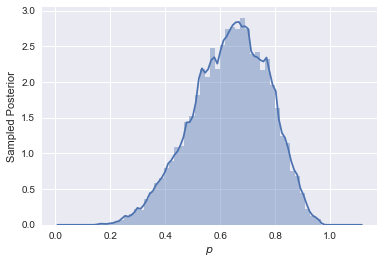

In [85]:
sns.distplot(samples,norm_hist=True, kde_kws={'bw':.05})
plt.ylabel('Sampled Posterior')
plt.xlabel('$p$')

In [87]:
quantiles=[np.percentile(samples,i) for i in [16,50,84]]
quantiles

[0.49449449449449451, 0.64464464464464466, 0.77777777777777779]

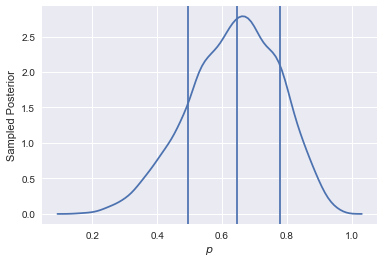

In [88]:
sns.kdeplot(samples)
for i in quantiles:
    plt.axvline(i)
plt.ylabel('Sampled Posterior')
plt.xlabel('$p$')

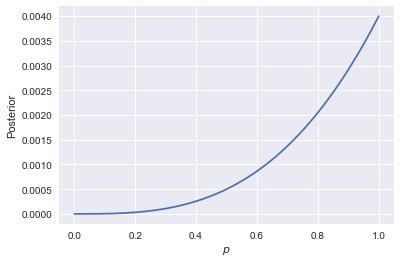

In [89]:
post_grid=np.array([posterior(i,3,3) for i in pgrid])
post_grid=post_grid/post_grid.sum()
plt.plot(pgrid,post_grid)
plt.xlabel('$p$')
plt.ylabel('Posterior')

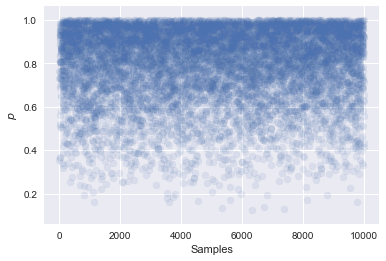

In [90]:
samples=np.random.choice(pgrid, nsamp, p=post_grid)
plt.scatter(range(nsamp),samples, alpha=0.1)
plt.xlabel('Samples')
plt.ylabel('$p$')

[0.63163163163163161, 0.83883883883883881, 0.95695695695695693]


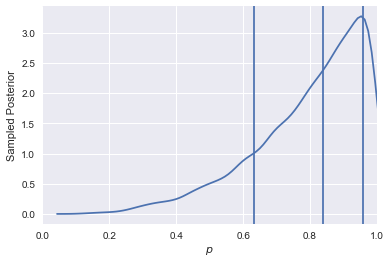

In [94]:
quantiles=[np.percentile(samples,i) for i in [16,50,84]]
sns.kdeplot(samples)
for i in quantiles:
    plt.axvline(i)
plt.ylabel('Sampled Posterior')
plt.xlabel('$p$')
plt.xlim(0,1)
print(quantiles)

[0.56156156156156167, 0.97397397397397401]


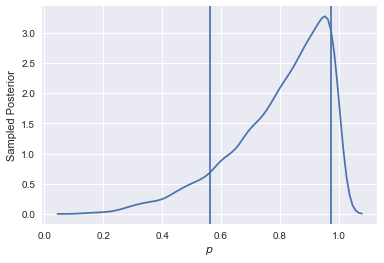

In [92]:
quantiles=[np.percentile(samples,i) for i in [10,90]]
sns.kdeplot(samples)
for i in quantiles:
    plt.axvline(i)
plt.ylabel('Sampled Posterior')
plt.xlabel('$p$')
print(quantiles)

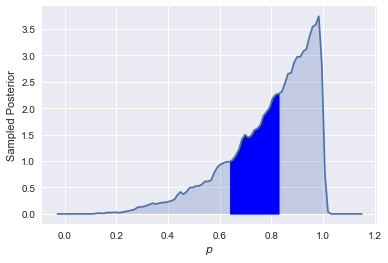

In [96]:
points = sns.kdeplot(samples, shade=True,bw=0.05).get_lines()[0].get_data()

x = points[0]
y = points[1]

plt.fill_between(x,y, where = (x>=quantiles[0]) & (x<=quantiles[1]), color='b')
plt.ylabel('Sampled Posterior')
plt.xlabel('$p$')
